In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

TASK = 'cpg_methylation'
MODEL = 'hyenadna-tiny-1k'

results_dir = '../../results/shuffle_experiment'

# Default, Shuffled embeddings, Shuffled Sequential on the fly, Shuffled Batch on the fly

In [ ]:
def read_results(experiment_path, variant,df_filename):
    df = pd.read_csv(os.path.join(experiment_path, variant, df_filename))
    df['Experiment'] = experiment
    df['Variant'] = variant
    return df

dfs_losses = []
dfs_tests = []

for experiment in os.listdir(results_dir):

    print(f'Processing {experiment}...')
    experiment_path = os.path.join(results_dir, experiment, TASK)

    for variant in os.listdir(experiment_path):
        print(f'\t Processing {variant}...')
    
        dfs_losses.append(read_results(experiment_path, variant,'losses.csv'))
        dfs_tests.append(read_results(experiment_path, variant,'best_model_metrics.csv'))

df_losses = pd.concat(dfs_losses, ignore_index=True)
df_tests = pd.concat(dfs_tests, ignore_index=True)        

In [18]:
df_50000 = df_losses[~df_losses['Experiment'].str.contains('workers')]
df_50000 = df_50000[df_losses['Variant']==MODEL]
df_50000

/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_17281/1453996153.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_50000 = df_50000[df_losses['Variant']==MODEL]


,Epoch,train_loss,val_loss,val_auroc,Experiment,Variant
400,1,0.300075,0.287327,0.868285,Shuffled Default,hyenadna-tiny-1k
401,2,0.281874,0.286768,0.869388,Shuffled Default,hyenadna-tiny-1k
402,3,0.277614,0.283214,0.872717,Shuffled Default,hyenadna-tiny-1k
403,4,0.275117,0.285149,0.869880,Shuffled Default,hyenadna-tiny-1k
404,5,0.272523,0.278487,0.878018,Shuffled Default,hyenadna-tiny-1k
...,...,...,...,...,...,...
1195,96,0.227297,0.252832,0.902415,Shuffled Batch On-the-fly,hyenadna-tiny-1k
1196,97,0.228261,0.259226,0.896149,Shuffled Batch On-the-fly,hyenadna-tiny-1k
1197,98,0.228134,0.250860,0.904296,Shuffled Batch On-the-fly,hyenadna-tiny-1k
1198,99,0.227282,0.252102,0.904164,Shuffled Batch On-the-fly,hyenadna-tiny-1k


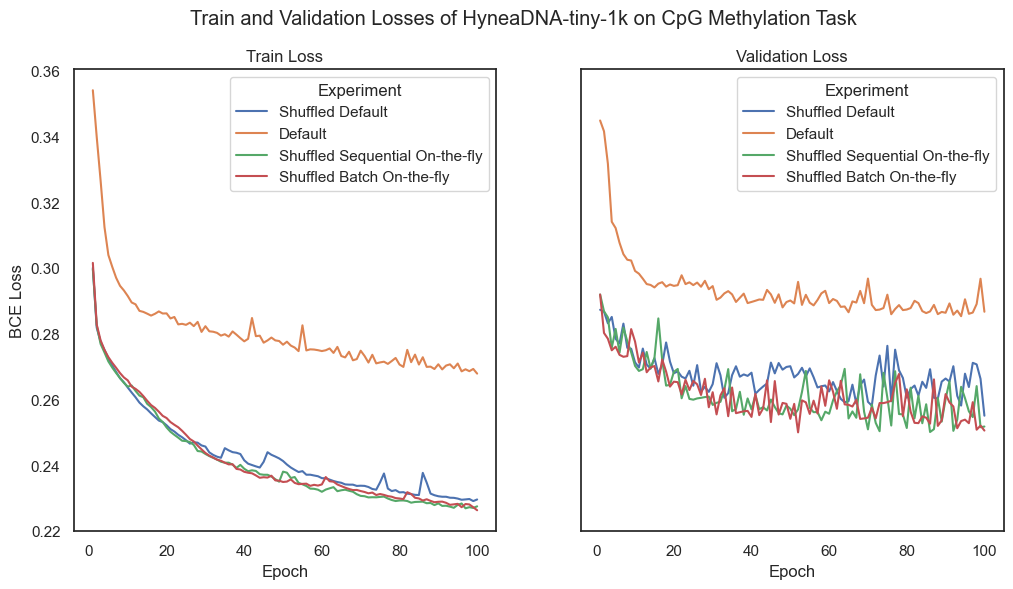

In [11]:
sns.set_theme(style="white")

fig, ax = plt.subplots(ncols=2, figsize=(12, 6), sharex=False, sharey=True)

sns.lineplot(data=df_50000, x='Epoch', y='train_loss', hue='Experiment', ax=ax[0])
sns.lineplot(data=df_50000, x='Epoch', y='val_loss', hue='Experiment', ax=ax[1])
ax[0].set(title='Train Loss', ylabel='BCE Loss')
ax[1].set(title='Validation Loss')
plt.suptitle(f'Train and Validation Losses of HyneaDNA-tiny-1k on CpG Methylation Task')
plt.savefig(f'losses_{MODEL}.png', dpi=300)

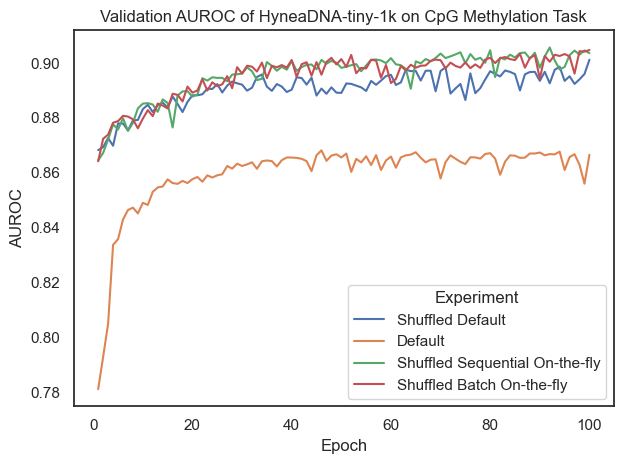

In [12]:
sns.lineplot(data=df_50000, x='Epoch', y='val_auroc', hue='Experiment')

plt.ylabel('AUROC')
plt.title(f'Validation AUROC of HyneaDNA-tiny-1k on CpG Methylation Task')
plt.tight_layout()
plt.savefig(f'val_AUROC_{MODEL}.png', dpi=300)

In [19]:
df_tests_5000 = df_tests[df_tests['Variant']==MODEL]
df_tests_5000 = df_tests_5000[~df_tests_5000['Experiment'].str.contains('workers')]
df_tests_5000[['Experiment','Variant','Epoch', 'train_loss','val_loss','test_auroc_avg']].sort_values(by='test_auroc_avg', ascending=False)

,Experiment,Variant,Epoch,train_loss,val_loss,test_auroc_avg
11,Shuffled Batch On-the-fly,hyenadna-tiny-1k,100.0,0.226367,0.250596,0.903395
10,Shuffled Sequential On-the-fly,hyenadna-tiny-1k,92.0,0.227741,0.250505,0.902340
4,Shuffled Default,hyenadna-tiny-1k,100.0,0.229641,0.255115,0.899255
8,Default,hyenadna-tiny-1k,46.0,0.278005,0.289445,0.864201


### Compare Default to Shuffled Batch on the fly

In [14]:
def get_results_dfs(dir_path):

    losses_path = os.path.join(dir_path, 'losses.csv')
    losses_df = pd.read_csv(losses_path)
    
    val_auroc_df = losses_df.loc[:, ['Epoch', 'val_auroc']]
    
    losses_df = pd.melt(losses_df.loc[:,losses_df.columns!='val_auroc'], id_vars='Epoch', var_name='Split', value_name='BCE Loss')

    results_path = os.path.join(dir_path, 'best_model_metrics.csv')
    results_df = pd.read_csv(results_path)
    
    return losses_df, val_auroc_df, results_df


bt_losses, bt_val_auroc, bt_results = get_results_dfs(os.path.join(results_dir,'Default', TASK, MODEL))
onthefly_losses, onthefly_val_auroc, onthefly_results = get_results_dfs(os.path.join(results_dir,'Shuffled Batch On-the-fly', TASK, MODEL))

In [15]:
print(f"BaseTrainer - {TASK} mean AUROC: {bt_results['test_auroc_avg'].iloc[0]}")
print(f"OnTheFly - {TASK} mean AUROC: {onthefly_results['test_auroc_avg'].iloc[0]}")

BaseTrainer - cpg_methylation mean AUROC: 0.8642010410697261
OnTheFly - cpg_methylation mean AUROC: 0.9033952871782356


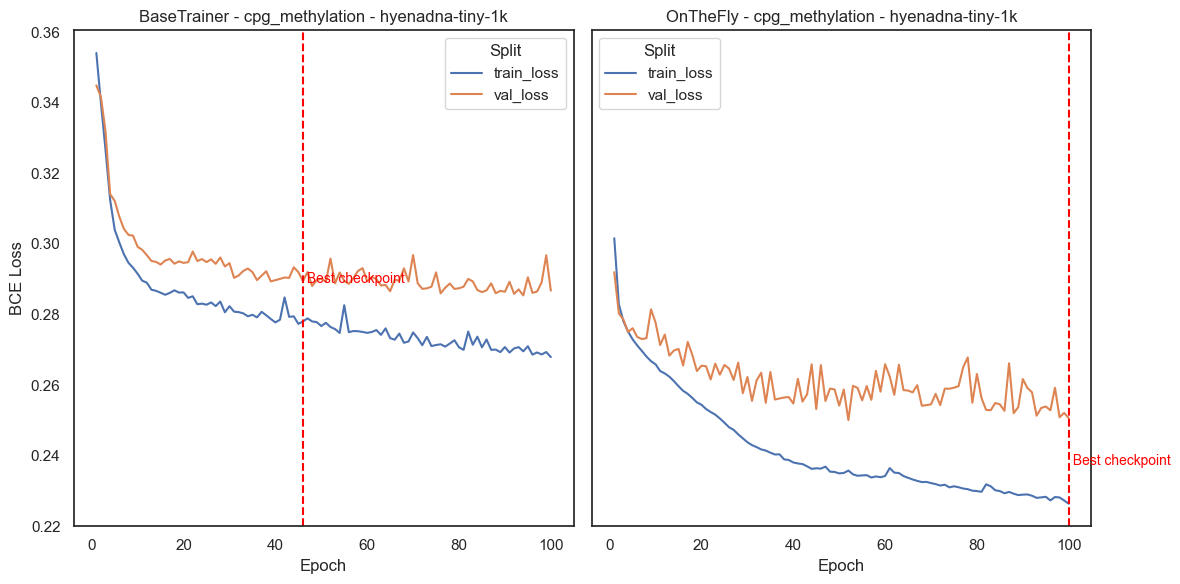

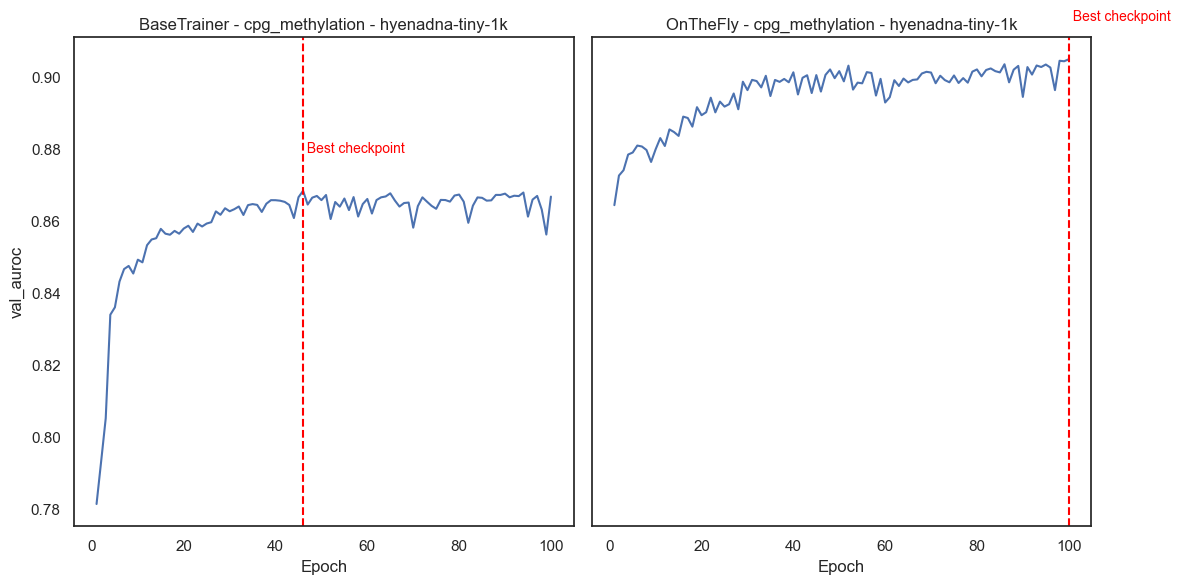

In [16]:
def print_checkpoint(ax, results_df, value_col='train_loss'):
    ax.axvline(x=results_df['Epoch'][0], color='red', linestyle='--', linewidth=1.5)
    ax.text(results_df['Epoch'][0], results_df[value_col][0]+.01, ' Best checkpoint', 
            horizontalalignment='left', verticalalignment='bottom', color='red', fontsize=10)

sns.set_theme(style="white")

fig, ax = plt.subplots(ncols=2, figsize=(12, 6), sharex=True, sharey=True)
sns.lineplot(data=bt_losses, x='Epoch', y='BCE Loss', hue='Split', ax=ax[0])
sns.lineplot(data=onthefly_losses, x='Epoch', y='BCE Loss', hue='Split', ax=ax[1])
ax[0].set_title(f'BaseTrainer - {TASK} - {MODEL}')
print_checkpoint(ax[0], bt_results)
ax[1].set_title(f'OnTheFly - {TASK} - {MODEL}')
print_checkpoint(ax[1], onthefly_results)
plt.tight_layout()

fig, ax = plt.subplots(ncols=2, figsize=(12,6),sharex=True, sharey=True)
sns.lineplot(data=bt_val_auroc, x='Epoch', y='val_auroc', ax=ax[0])
sns.lineplot(data=onthefly_val_auroc, x='Epoch', y='val_auroc', ax=ax[1])
ax[0].set_title(f'BaseTrainer - {TASK} - {MODEL}')
print_checkpoint(ax[0], bt_results, value_col='val_auroc')
ax[1].set_title(f'OnTheFly - {TASK} - {MODEL}')
print_checkpoint(ax[1], onthefly_results, value_col='val_auroc')
plt.tight_layout()


### Impact of number of workers

In [57]:
df_works = df_losses[df_losses['Experiment'].str.contains('Default')]
df_works = df_works[df_works['Variant']==MODEL]
df_works

,Epoch,train_loss,val_loss,val_auroc,Experiment,Variant
0,1,0.330644,0.321296,0.834721,Default max workers,hyenadna-tiny-1k
1,2,0.304027,0.310029,0.840785,Default max workers,hyenadna-tiny-1k
2,3,0.298320,0.316784,0.849526,Default max workers,hyenadna-tiny-1k
3,4,0.293795,0.316271,0.853136,Default max workers,hyenadna-tiny-1k
4,5,0.290934,0.308455,0.853942,Default max workers,hyenadna-tiny-1k
...,...,...,...,...,...,...
995,96,0.230306,0.270654,0.886602,Shuffled Default max workers,hyenadna-tiny-1k
996,97,0.229181,0.277803,0.887251,Shuffled Default max workers,hyenadna-tiny-1k
997,98,0.230056,0.288573,0.889284,Shuffled Default max workers,hyenadna-tiny-1k
998,99,0.230063,0.296789,0.894076,Shuffled Default max workers,hyenadna-tiny-1k


Text(0.5, 0.98, 'Train and Validation Losses of HyneaDNA-tiny-1k on CpG Methylation Task')

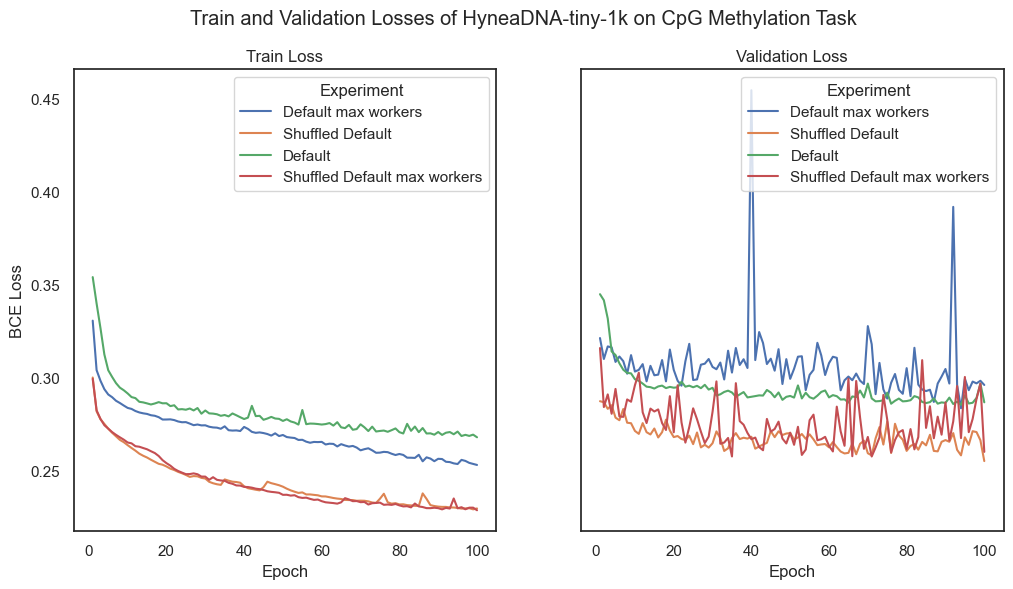

In [59]:
sns.set_theme(style="white")

fig, ax = plt.subplots(ncols=2, figsize=(12, 6), sharex=False, sharey=True)

sns.lineplot(data=df_works, x='Epoch', y='train_loss', hue='Experiment', ax=ax[0])
sns.lineplot(data=df_works, x='Epoch', y='val_loss', hue='Experiment', ax=ax[1])
ax[0].set(title='Train Loss', ylabel='BCE Loss')
ax[1].set(title='Validation Loss')
plt.suptitle(f'Train and Validation Losses of HyneaDNA-tiny-1k on CpG Methylation Task')